# Improving Potato Disease Classification With Convolutional Neural Network And Feature Fusion 

# Introduction 
The introduction of this study aims to address the growing need for accurate potato disease detection, a critical issue for agriculture. Using deep learning techniques, we propose a model that integrates RGB and grayscale images to improve disease prediction accuracy. By leveraging advanced image processing and machine learning methods, this study seeks to identify and classify potato diseases effectively. This approach not only helps in timely intervention but also supports farmers in making informed decisions to manage crop health and reduce losses.

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

LODING THE DATASET
Here are the key reasons to use TensorFlow `tf.data`:

1. **Efficient Data Loading**: Handles large datasets efficiently, minimizing memory usage and improving performance.

2. **Preprocessing Pipelines**: Provides tools for on-the-fly data preprocessing, including augmentation, normalization, and shuffling.

3. **Scalability**: Works seamlessly with distributed training on multiple GPUs or TPUs.

4. **Customizable**: Offers flexibility to create complex pipelines with `map`, `filter`, and `batch` operations.

5. **Integration**: Optimized for TensorFlow models, ensuring smooth data feeding during training and evaluation.

6. **Streaming Data**: Supports loading and processing data in real-time from various sources, like files, APIs, or streams.

7. **Performance Boost**: Allows parallel processing, caching, and prefetching to speed up training.

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True, #randomly shuffling the images 
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


the folder names are the classes names 

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Every elements in the dataset is the batch of 32 images 

In [6]:
len(dataset)

68

In [7]:
68*32

2176

Each btach has 32 images of size 256x256 and there are 3 channel RGB
1 batch has 32 images 
each image is 256x256x3

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 0 1 1 1 0 1 1 1 2 1 1 1 0 1 1 1 0 2 0 2 0 1 0 1 1 2]


The shape of the first Image

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


setup Figure: Creates a 10x10 figure for plotting.
Fetch Batch: Takes one batch of images and labels from the dataset.
Loop: Iterates over the first 12 images in the batch.
Subplot: Displays each image in a 3x4 grid.
Title: Sets the title of each subplot to the corresponding class name.
Hide Axis: Removes axes for a cleaner view.

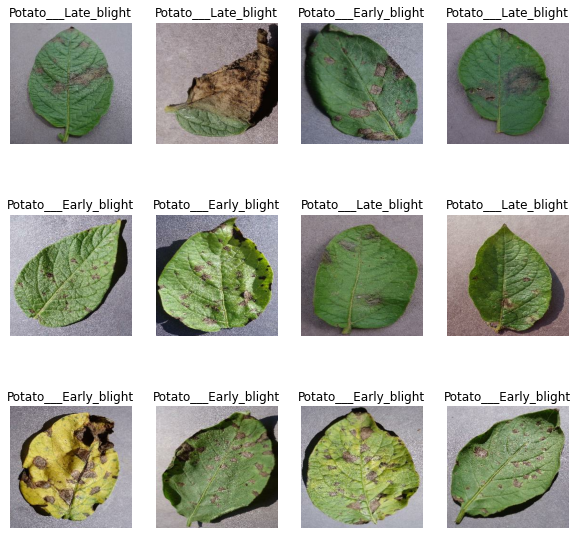

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

actuall length is 32x68 as each batch size is 32

In [11]:
len(dataset)

68

80% ==> traning
20% ==> 10% validation, 10% test

validation will be used during training. After done each epoch you will do validation on this 10%

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Till now we have done the train test split using the numbers as we know now we will be wraping it up in a python function.


In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds) #dataset size
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)    #seed just for predictibility 
    
    train_size = int(train_split * ds_size) #80% of dataset
    val_size = int(val_split * ds_size)     #validation 
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.take(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) #calling he above function on our dataset

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

This code optimizes the data pipelines for training, validation, and testing datasets using `tf.data` transformations. Here's a breakdown:

1. **`cache()`**:
   - Stores the dataset in memory (or a local file if specified) to avoid redundant computations during multiple epochs.

2. **`shuffle(1000)`**:
   - Randomizes the order of elements in the dataset with a buffer size of 1000, improving model generalization.

3. **`prefetch(buffer_size=tf.data.AUTOTUNE)`**:
   - Overlaps data preprocessing with model training by prefetching data in the background, reducing idle time. `AUTOTUNE` dynamically adjusts the prefetch buffer size for optimal performance.

This combination ensures efficient, randomized, and concurrent data loading for all datasets.

In [23]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

This code defines a preprocessing pipeline using TensorFlow's Keras `Sequential` model. The pipeline includes two layers: `Resizing` and `Rescaling`. The `Resizing` layer adjusts the dimensions of input images to a uniform size defined by `IMAGE_SIZE`, ensuring consistency in input shape for the model. The `Rescaling` layer normalizes pixel values by scaling them to the range [0, 1], dividing each pixel value by 255. This preprocessing is essential for preparing images for training deep learning models, as it standardizes input data and improves model performance.

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

The code defines a data augmentation pipeline using TensorFlow's Keras `Sequential` model, which applies random transformations to input images during training to enhance dataset diversity. It includes two layers: `RandomFlip`, which randomly flips images both horizontally and vertically to introduce variability in orientation, and `RandomRotation`, which rotates images randomly by up to 20% of a full circle. These augmentations help the model become more robust to positional and rotational variations, improving generalization and reducing the risk of overfitting.

In [25]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

CNN Convolutional Neural Network 
there will be set of layers
1st resize and rescale layer whenever you feed an image first resize it and then scale it by dividing by 255
2nd data audmentation layer do vertical horizontal flips to generate new samples 
3rd covolutional layes arguments 32:number of filters (3,3):kernal size, activation layer:relu because its very fast to compute 
input shape: 256,256
4th pooling 
next flatten it so that its an array of neuron 

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

C:\Users\hp\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The given model is a Convolutional Neural Network (CNN) designed for image classification into three categories. It begins with an input layer that accepts batches of RGB images with dimensions 256x256x3. The model uses sequential layers to organize the architecture, followed by multiple convolutional layers (Conv2D) for feature extraction. These layers use 3x3 filters to detect patterns in the input images, with the number of filters increasing in deeper layers to capture more complex features. Each convolutional layer is followed by a max-pooling layer, which downsamples the spatial dimensions by half to reduce computational complexity and extract dominant features.

As the spatial dimensions decrease, the depth (number of feature maps) increases, allowing the model to learn more abstract features. After the final convolutional and max-pooling layers, the feature maps are flattened into a 1D vector. This vector is then passed through a fully connected dense layer with 64 neurons, which learns high-level global patterns. The final dense layer has 3 neurons, corresponding to the 3 output classes, and uses a softmax activation function for classification. The model has a total of 183,747 trainable parameters, which are updated during training to optimize performance. This architecture efficiently combines convolutional operations, pooling, and fully connected layers to classify images with high accuracy.

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 **Adam** (Adaptive Moment Estimation) is an optimization algorithm for training machine learning models, particularly deep learning ones. It combines the benefits of both AdaGrad and RMSprop algorithms. Adam adapts the learning rate for each parameter by using first moment estimates (mean) and second moment estimates (uncentered variance) of gradients. This helps to speed up the convergence process and performs well on large-scale problems with sparse gradients. Stochastic gradient descent 

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), #using softmax activation function 
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 806ms/step - accuracy: 0.4863 - loss: 0.9354 - val_accuracy: 0.4635 - val_loss: 0.9338
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 690ms/step - accuracy: 0.5527 - loss: 0.8391 - val_accuracy: 0.4948 - val_loss: 0.8511
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 676ms/step - accuracy: 0.7251 - loss: 0.5953 - val_accuracy: 0.7448 - val_loss: 0.6406
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 639ms/step - accuracy: 0.8134 - loss: 0.4235 - val_accuracy: 0.8438 - val_loss: 0.3629
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 642ms/step - accuracy: 0.8617 - loss: 0.3094 - val_accuracy: 0.8438 - val_loss: 0.3681
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 686ms/step - accuracy: 0.8659 - loss: 0.3348 - val_accuracy: 0.9010 - val_loss: 0.2622
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 645ms/step - accuracy: 0.9246 - loss: 0.2070 - val_accuracy: 0.9062 - val_loss: 0.1884
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step - accuracy: 0.9188 - loss: 0.2061 - val_accu

In [30]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9847 - loss: 0.0552


In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
history.history['accuracy']

[0.5069444179534912,
 0.6232394576072693,
 0.7599765062332153,
 0.8333333134651184,
 0.8790509104728699,
 0.8877314925193787,
 0.9184027910232544,
 0.9266431927680969,
 0.9442488551139832,
 0.9307511448860168,
 0.920187771320343,
 0.9295774698257446,
 0.9512910842895508,
 0.954812228679657,
 0.966549277305603,
 0.940727710723877,
 0.9448356628417969,
 0.9606807231903076,
 0.954812228679657,
 0.96772301197052,
 0.9618544578552246,
 0.9730046987533569,
 0.9753521084785461,
 0.9642018675804138,
 0.9642018675804138,
 0.9782863855361938,
 0.9630281925201416,
 0.9788732528686523,
 0.9771126508712769,
 0.9730046987533569,
 0.9788732528686523,
 0.9782863855361938,
 0.9759389758110046,
 0.9917840361595154,
 0.9835680723190308,
 0.9812206625938416,
 0.9788732528686523,
 0.9849537014961243,
 0.9724178314208984,
 0.9735915660858154,
 0.9826388955116272,
 0.9882628917694092,
 0.9917840361595154,
 0.9794601202011108,
 0.9806337952613831,
 0.9894366264343262,
 0.9865023493766785,
 0.9923709034919739,

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

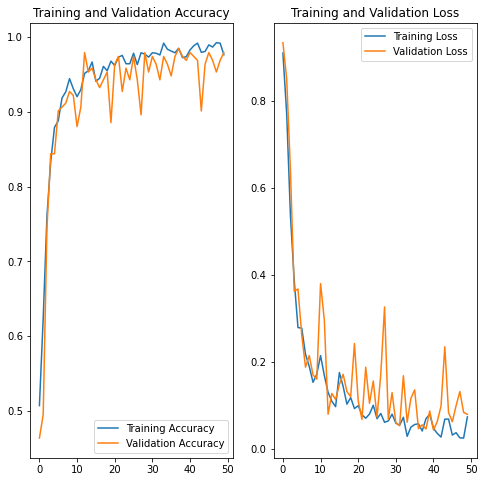

In [36]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
actual label:  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
[5.1078519e-08 6.1009490e-05 9.9993896e-01]
2
predicted_label:  Potato___healthy


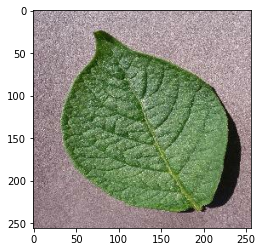

In [37]:
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('actual label: ', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("predicted_label: ", class_names[np.argmax(batch_prediction[0])])


In [38]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


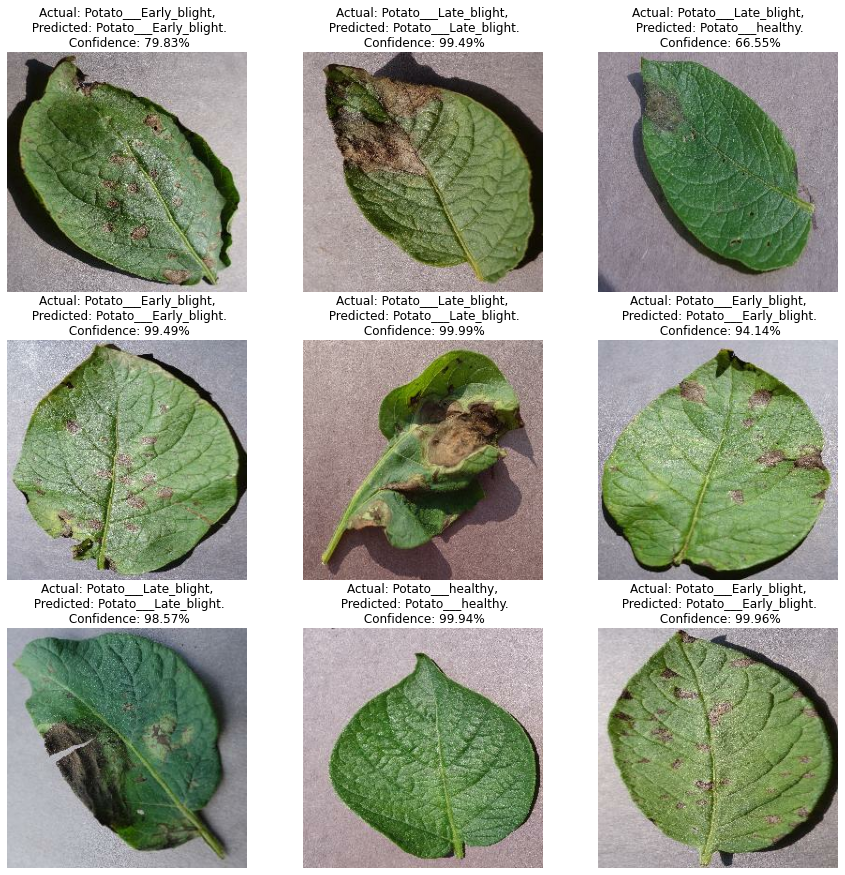

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [41]:
# Ensure the directory exists
import os
os.makedirs("../models/", exist_ok=True)

 #Save the model in the recommended Keras format
model_version = 1
model.save(f"../models/{model_version}.keras")


In [42]:
import os

# Get the next model version number
model_versions = [
    int(f.split('.')[0]) for f in os.listdir("../models") if f.split('.')[0].isdigit()
]
models_version = max(model_versions, default=0) + 1

# Save the model with the `.keras` extension
os.makedirs("../models/", exist_ok=True)
model.save(f"../models/{models_version}.keras")


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

# Resizing and Rescaling
resize_and_rescale = layers.Rescaling(1.0 / 255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Define the model with feature fusion
input_layer = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Preprocessing
x = resize_and_rescale(input_layer)
x = data_augmentation(x)

# Convolutional layers
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(x)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

conv4 = layers.Conv2D(64, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D((2, 2))(conv4)

# Feature Fusion: Concatenating features from different layers
# Use GlobalAveragePooling2D to reduce dimensionality before concatenation
features1 = layers.GlobalAveragePooling2D()(pool2)  # Features from early layer
features2 = layers.GlobalAveragePooling2D()(pool4)  # Features from deeper layer

fused_features = layers.Concatenate()([features1, features2])

# Fully connected layers
dense1 = layers.Dense(64, activation='relu')(fused_features)
output_layer = layers.Dense(n_classes, activation='softmax')(dense1)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Print the model summary to verify feature fusion
model.summary()

C:\Users\hp\anaconda3\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_3 (Sequential)     │ (None, 256, 256, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 254, 254, 32)      │             896 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 127, 127, 32)      │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 125, 125, 64)      │          18,496 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 62, 62, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 60, 60, 64)        │          36,928 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 30, 30, 64)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 28, 28, 64)        │          36,928 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 14, 14, 64)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 64)                │               0 │ max_pooling2d_7[0][0]      │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_1    │ (None, 64)                │               0 │ max_pooling2d_9[0][0]      │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ global_average_pooling2d[… │
│                               │                           │               

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

# Constants
IMAGE_SIZE = 256
CHANNELS = 3  # Change as per your input channel size
n_classes = 10  # Change according to your dataset

# Resizing and Rescaling
resize_and_rescale = layers.Rescaling(1.0 / 255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Define the model with feature fusion
input_layer = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Preprocessing
x = resize_and_rescale(input_layer)

# Apply data augmentation if input has 3 channels (RGB)
if CHANNELS == 3:
    x = data_augmentation(x)

# Convolutional layers
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(x)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

conv4 = layers.Conv2D(64, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D((2, 2))(conv4)

# Feature Fusion: Concatenating features from different layers
features1 = layers.GlobalAveragePooling2D()(pool2)  # Features from early layer
features2 = layers.GlobalAveragePooling2D()(pool4)  # Features from deeper layer

fused_features = layers.Concatenate()([features1, features2])

# Fully connected layers
dense1 = layers.Dense(64, activation='relu')(fused_features)
output_layer = layers.Dense(n_classes, activation='softmax')(dense1)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Print the model summary to verify feature fusion
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 256, 256, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_4 (Sequential)     │ (None, 256, 256, 3)       │               0 │ rescaling_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 254, 254, 32)      │             896 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 127, 127, 32)      │               0 │ conv2d_10[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 125, 125, 64)      │          18,496 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_11              │ (None, 62, 62, 64)        │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 60, 60, 64)        │          36,928 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 30, 30, 64)        │               0 │ conv2d_12[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 28, 28, 64)        │          36,928 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_13              │ (None, 14, 14, 64)        │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_2    │ (None, 64)                │               0 │ max_pooling2d_11[0][0]     │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_3    │ (None, 64)                │               0 │ max_pooling2d_13[0][0]     │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 128)               │               0 │ global_average_pooling2d_… │
│                               │                           │               

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Constants
IMAGE_SIZE = 256
CHANNELS = 3  # Change as per your input channel size
n_classes = len(class_names)  # Number of classes based on your dataset

# Dataset Preparation
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32
)


Found 2152 files belonging to 3 classes.


In [47]:
# Dataset Partitions
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.take(train_size).skip(val_size)
    test_ds = ds.skip(train_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [48]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Feature Fusion Model
input_layer = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Preprocessing
x = layers.Rescaling(1.0 / 255)(input_layer)
x = data_augmentation(x)

In [49]:
# Convolutional layers
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(x)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

conv4 = layers.Conv2D(64, (3, 3), activation='relu')(pool3)
pool4 = layers.MaxPooling2D((2, 2))(conv4)

In [50]:

# Feature Fusion: Concatenating features from different layers
features1 = layers.GlobalAveragePooling2D()(pool2)  # Features from early layer
features2 = layers.GlobalAveragePooling2D()(pool4)  # Features from deeper layer

fused_features = layers.Concatenate()([features1, features2])


In [51]:
# Fully connected layers
dense1 = layers.Dense(64, activation='relu')(fused_features)
output_layer = layers.Dense(n_classes, activation='softmax')(dense1)


In [52]:
# Final model
model = Model(inputs=input_layer, outputs=output_layer)


In [53]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
# Training the model
history = model.fit(
    train_ds,
    epochs=50,  # Change according to your requirement
    batch_size=32,  # Adjust as needed
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 976ms/step - accuracy: 0.4614 - loss: 0.9351 - val_accuracy: 0.4616 - val_loss: 0.8956
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 922ms/step - accuracy: 0.5614 - loss: 0.8631 - val_accuracy: 0.5132 - val_loss: 0.9135
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 920ms/step - accuracy: 0.6672 - loss: 0.7518 - val_accuracy: 0.7995 - val_loss: 0.5547
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 880ms/step - accuracy: 0.7836 - loss: 0.5613 - val_accuracy: 0.8320 - val_loss: 0.4323
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 916ms/step - accuracy: 0.8849 - loss: 0.3493 - val_accuracy: 0.7870 - val_loss: 0.6001
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 905ms/step - accuracy: 0.9200 - loss: 0.2156 - val_accuracy: 0.8565 - val_loss: 0.3807
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 884ms/step - accuracy: 0.9567 - loss: 0.1334 - val_accuracy: 0.7216 - val_loss: 1.0296
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 872ms/step - accuracy: 0.9259 - loss: 0.2022 - val_accu

In [55]:
# Evaluation on the test set
test_scores = model.evaluate(test_ds)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9236 - loss: 0.1994
Test Loss: 0.18629582226276398
Test Accuracy: 0.9292452931404114


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


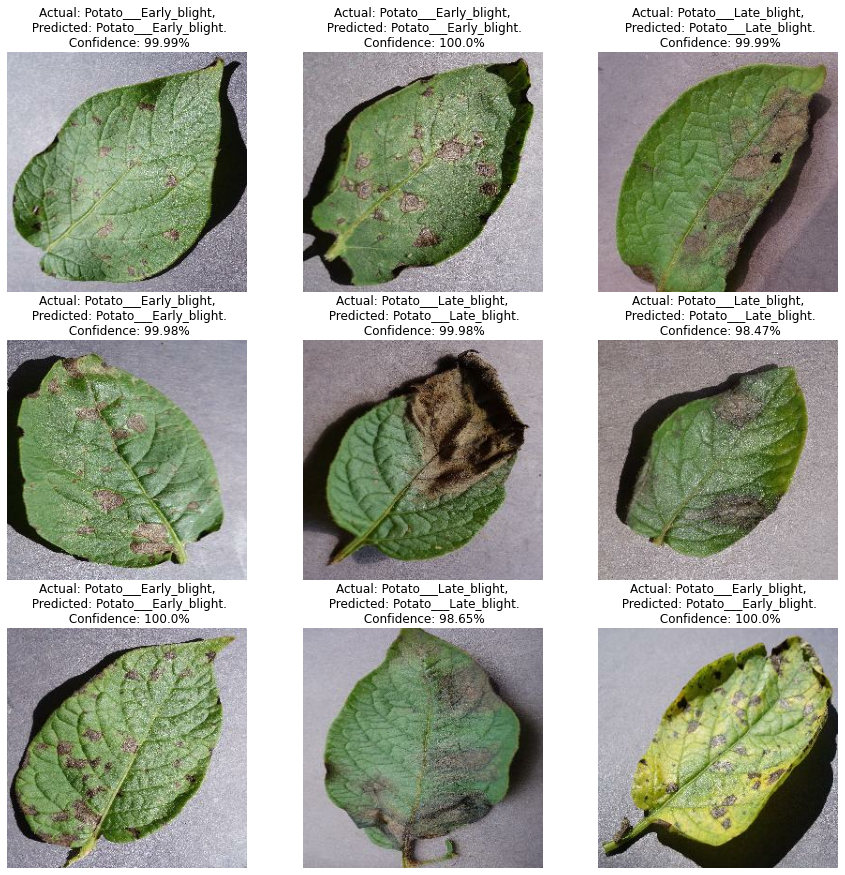

In [56]:
# Prediction and displaying results
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

# Display predictions on test images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i], class_names)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

# Save the model
import os

# Get the next model version number
model_versions = [
    int(f.split('.')[0]) for f in os.listdir("../models") if f.split('.')[0].isdigit()
]
models_version = max(model_versions, default=0) + 1

# Save the model with the `.keras` extension
os.makedirs("../models/", exist_ok=True)
model.save(f"../models/{models_version}.keras")


# Early Fusion: Combining RGB and grayscale inputs


**Early Fusion** refers to the technique of combining different input modalities, such as RGB and grayscale images, at an early stage of the model architecture. In this approach, both types of images are fed simultaneously into the model, which then learns to extract shared and complementary features. This can improve the model's performance by leveraging more information from different input types, potentially leading to better generalization.

The code defines an **early fusion** deep learning model that combines multiple input features (like RGB and grayscale) before feeding them into the network. It starts with an input layer and applies convolutional layers to extract features, followed by max pooling to reduce dimensionality. The network then flattens the output and passes it through dense layers with ReLU activation, concluding with a softmax output layer for classification. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss for multi-class classification.

In [57]:
# Early Fusion: Combining multiple input features before feeding them into the model.
def early_fusion_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=3):
    input_layer = layers.Input(shape=input_shape)

    # Early fusion applied here (e.g., stacking channels, concatenating input data)
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

early_model = early_fusion_model()
early_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 903ms/step - accuracy: 0.5577 - loss: 889.3658 - val_accuracy: 0.8869 - val_loss: 0.4152
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 877ms/step - accuracy: 0.9148 - loss: 0.3674 - val_accuracy: 0.9683 - val_loss: 0.1268
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 927ms/step - accuracy: 0.9692 - loss: 0.1433 - val_accuracy: 0.9947 - val_loss: 0.0667
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.9932 - loss: 0.0491 - val_accuracy: 0.9980 - val_loss: 0.0146
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 876ms/step - accuracy: 0.9953 - loss: 0.0318 - val_accuracy: 0.9974 - val_loss: 0.0068
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 836ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 813ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 8.1894e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 890ms/step - accuracy: 0.9989 - loss: 0.0050 - va

54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 809ms/step - accuracy: 1.0000 - loss: 6.4449e-06 - val_accuracy: 1.0000 - val_loss: 4.7320e-06
Epoch 50/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 825ms/step - accuracy: 1.0000 - loss: 5.7243e-06 - val_accuracy: 1.0000 - val_loss: 4.2700e-06
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 1.0000 - loss: 1.0619e-05
Early Fusion Model - Test Loss: 5.797227004222805e-06, Test Accuracy: 1.0


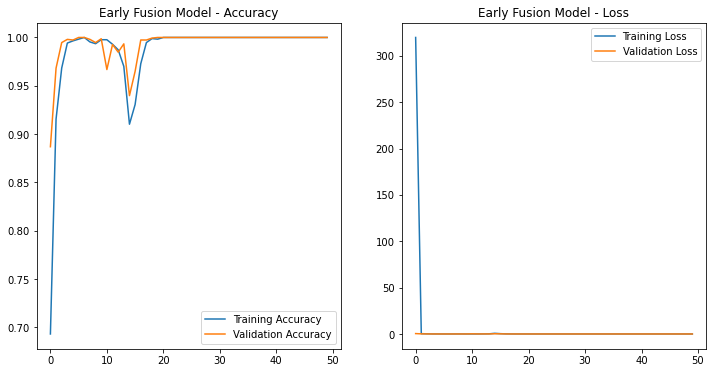

In [58]:
# Train the early fusion model
history_early = early_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Evaluate the early fusion model on the test dataset
test_loss_early, test_accuracy_early = early_model.evaluate(test_ds, verbose=1)
print(f"Early Fusion Model - Test Loss: {test_loss_early}, Test Accuracy: {test_accuracy_early}")

# Plot training and validation performance
acc = history_early.history['accuracy']
val_acc = history_early.history['val_accuracy']
loss = history_early.history['loss']
val_loss = history_early.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Early Fusion Model - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Early Fusion Model - Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


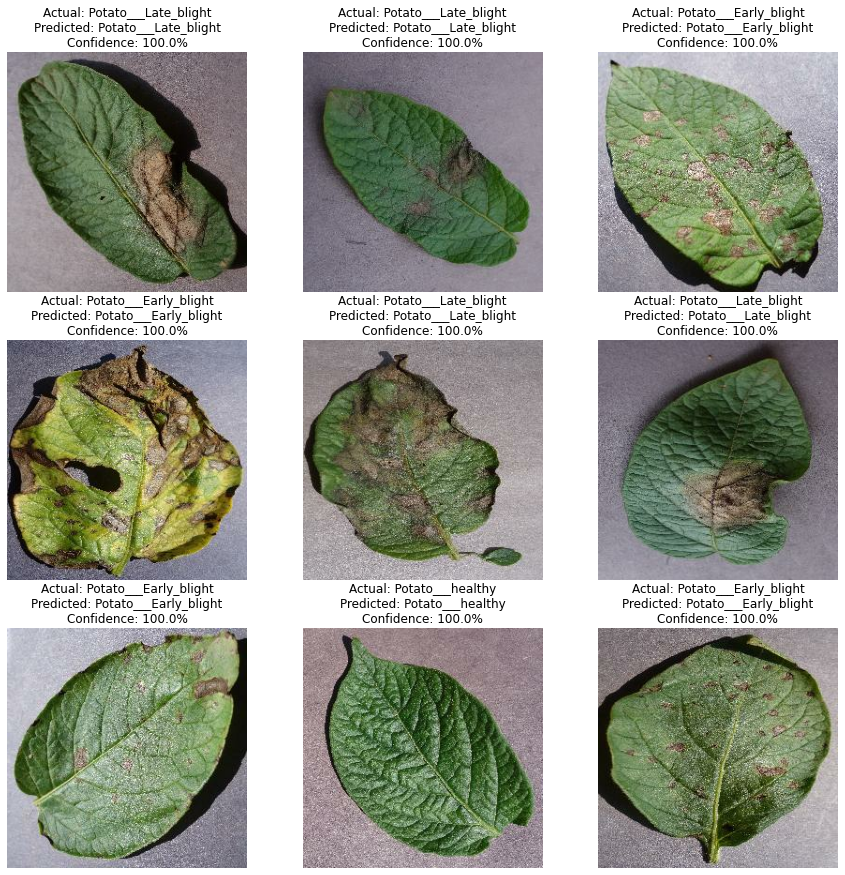

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Helper function for predictions
def predict_and_visualize(model, dataset, class_names):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  # Take one batch from the test dataset
        for i in range(9):  # Show the first 9 images and predictions
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy().astype("uint8")  # Convert tensor to image
            label = labels[i].numpy()

            # Predict using the model
            img_array = tf.expand_dims(img, axis=0)  # Add batch dimension
            predictions = model.predict(img_array)
            predicted_class = class_names[np.argmax(predictions[0])]
            confidence = round(100 * np.max(predictions[0]), 2)

            # Visualization
            plt.imshow(img)
            actual_class = class_names[label]
            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
            plt.axis("off")
    plt.show()

# Call the function to visualize predictions on the test dataset
predict_and_visualize(early_model, test_ds, class_names)


# late fusion 

**Late Fusion** refers to the method of combining multiple input sources (like RGB and grayscale images) at a later stage in the model architecture. Instead of integrating the inputs early on, they are processed separately through different pathways (networks) and their outputs are fused together at a later stage, such as at the feature level or at the final output. This allows each modality to maintain its specific characteristics before combining for a more informed decision.q1`

In [60]:
# Late Fusion: Combining outputs from separate models before final classification.
def late_fusion_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=3):
    input_layer = layers.Input(shape=input_shape)

    # Branch 1
    branch1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    branch1 = layers.MaxPooling2D((2, 2))(branch1)
    branch1 = layers.Flatten()(branch1)

    # Branch 2
    branch2 = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Flatten()(branch2)

    # Late fusion
    fused = layers.concatenate([branch1, branch2], axis=-1)

    x = layers.Dense(128, activation='relu')(fused)
    output_layer = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

late_model = late_fusion_model()
late_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2237s 41s/step - accuracy: 0.6742 - loss: 464.8291 - val_accuracy: 0.9431 - val_loss: 15.3489
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1974s 37s/step - accuracy: 0.9263 - loss: 18.9221 - val_accuracy: 0.9332 - val_loss: 14.4251
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1979s 37s/step - accuracy: 0.9646 - loss: 8.0848 - val_accuracy: 0.9841 - val_loss: 2.9594
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1916s 35s/step - accuracy: 0.9558 - loss: 8.2607 - val_accuracy: 0.9894 - val_loss: 0.9290
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1864s 34s/step - accuracy: 0.9853 - loss: 1.8425 - val_accuracy: 0.9888 - val_loss: 1.1989
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1940s 36s/step - accuracy: 0.9890 - loss: 0.8041 - val_accuracy: 0.9974 - val_loss: 0.1412
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1786s 33s/step - accuracy: 0.9935 - loss: 0.7255 - val_accuracy: 0.9993 - val_loss: 0.0081
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1842s 34s/step - accuracy: 0.9963 - loss: 0.1759 - val

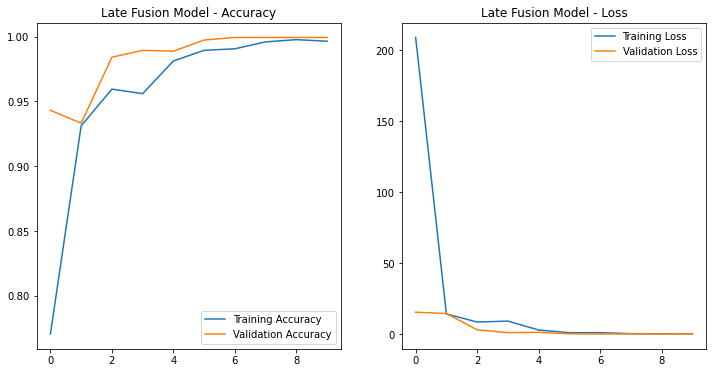

In [62]:
# Train the late fusion model
history_late = late_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=256,
    verbose=1
)
# Evaluate the late fusion model on the test dataset
test_loss_late, test_accuracy_late = late_model.evaluate(test_ds, verbose=1)
print(f"Late Fusion Model - Test Loss: {test_loss_late}, Test Accuracy: {test_accuracy_late}")
# Extract metrics from training history
acc_late = history_late.history['accuracy']
val_acc_late = history_late.history['val_accuracy']
loss_late = history_late.history['loss']
val_loss_late = history_late.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc_late, label='Training Accuracy')
plt.plot(val_acc_late, label='Validation Accuracy')
plt.legend()
plt.title('Late Fusion Model - Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss_late, label='Training Loss')
plt.plot(val_loss_late, label='Validation Loss')
plt.legend()
plt.title('Late Fusion Model - Loss')

plt.show()